# <font color = "red">Classificação de Risco de Crédito</font>

## PRÉ PROCESSAMENTO DOS DADOS E ENGENHARIA DE ATRIBUTOS 

<font color = "red">Problema de Negócio:</font> A partir de dados históricos, irei verificar os padrões que levaram os clientes de uma instituição financeira, a adentrarem, ou não, na situação de inadimplência, para posteriormente criar um 

<font color = "red">Meta de Acurácia Final:</font> ACC mínimo de 88%

<font color = "blue">Foco deste notebook será preparar os dados para a etapa de modelagem, aplicando codifica~ção às variáveis categóricas, escalonamento às numéricas e balanceamento de classe, se for necessário. Após, analisarei a importância das variáveis, juntamente com o relatório da análise exploratória, com intuito de remover variáveis irrelevantes e correlacionadas.

In [54]:
# Imports 
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Regularização de classe
from imblearn.over_sampling import SMOTE


# Feature Importance
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [34]:
# Importando os dados 
df = pd.read_csv("C:/Projetos Pessoais/DataScience/analise_Risco_Credito/data/df_para_pre_processamento_4.csv")

<font color = "red">Codificação das Variáveis

In [35]:
# Objeto Encoder e Standard
lb = LabelEncoder()
scaler = StandardScaler()

In [36]:
df_processing = df.copy()

- Label Encoder para variáveis

In [37]:
# Encoder para Varíavel Target
df_processing['Status_Pagamento'] = lb.fit_transform(df_processing['Status_Pagamento'])
df_processing['Inadimplencia_Historica'] = lb.fit_transform(df_processing['Inadimplencia_Historica'])

# Encoder em Grau emprestimo, pois há hierarquia dentro da variável - A é melhor q B
df_processing['Grau_Emprestimo'] = lb.fit_transform(df_processing['Grau_Emprestimo'])
df_processing.sample()


,Idade,Renda_Anual,Tipo_Moradia,Anos_no_Emprego,Motivo_Emprestimo,Grau_Emprestimo,Valor,Taxa_Juros,Status_Pagamento,Comprometimento_Renda,Inadimplencia_Historica,Duracao_Historico_Credito
20654,29.0,120000.0,Hipoteca,8.0,Empreendimento,0,5000.0,7.43,0,0.04,0,6.0


- Get Dummies para variáveis sem hierárquias e não binárias

In [38]:
df_processing = pd.get_dummies(df_processing, columns=['Tipo_Moradia', 'Motivo_Emprestimo'], drop_first=True)

In [39]:
# Os dados ficaram no formato True/False - transformar em 0 e 1
var_dummies = ['Tipo_Moradia_Hipoteca',	'Tipo_Moradia_Outro',	'Tipo_Moradia_Próprio',
               'Motivo_Emprestimo_Educação', 'Motivo_Emprestimo_Empreendimento', 'Motivo_Emprestimo_Médico',
            	'Motivo_Emprestimo_Pessoal', 'Motivo_Emprestimo_Reformas Domésticas']
for x in var_dummies:
    df_processing[x] = np.where(df_processing[x] == True, 1,0)

- Padonização dos Dados numéricos

In [45]:
var_padronizacao = ['Idade', 'Renda_Anual', 'Anos_no_Emprego', 'Valor', 'Taxa_Juros', 'Comprometimento_Renda', 'Duracao_Historico_Credito']

for var in var_padronizacao:
 df_processing[var] = scaler.fit_transform(df_processing[[var]])

<font color = "red">Regularizando Variável Target 

In [53]:
df_processing.Status_Pagamento.value_counts()

Status_Pagamento
0    17471
1     4262
Name: count, dtype: int64

Text(0.5, 1.0, 'Contagem das Classes\n')

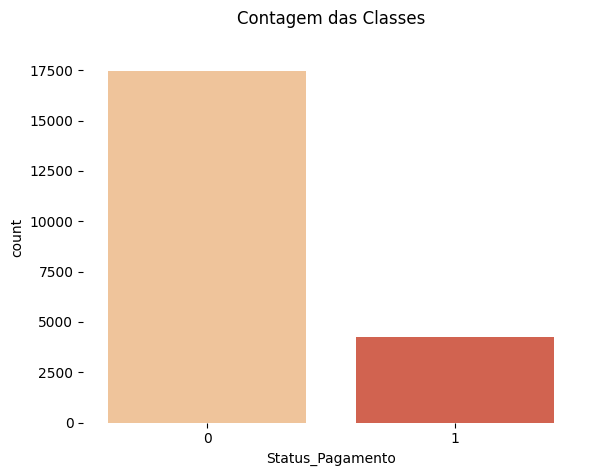

In [52]:
sns.countplot(x='Status_Pagamento', data=df_processing, palette= "OrRd")
plt.box(False)
plt.title("Contagem das Classes\n")

Podemos notar que a variável "0", que condiz à pessoas adimplentes, possui muitas amostras a mais. Isso prejudica o modelo, pois aprenderá muito mais sobre identificar a variável 0 do que a 1.
- Para isso, utilizarei o SMOTE, a fim de criar dados sintéticos com base nos originais

In [60]:
# Separa X e y
target = df_processing['Status_Pagamento']
features = df_processing.drop(columns=['Status_Pagamento'])

seed = 100

# Cria o balanceador SMOTE
smote_bal = SMOTE(random_state = seed)

# Aplica o balanceador
X, y = smote_bal.fit_resample(features, target)

In [61]:
X.shape

(34942, 17)

In [62]:
y.shape

(34942,)

In [63]:
y.value_counts()

Status_Pagamento
0    17471
1    17471
Name: count, dtype: int64

In [66]:
X.sample()

,Idade,Renda_Anual,Anos_no_Emprego,Grau_Emprestimo,Valor,Taxa_Juros,Comprometimento_Renda,Inadimplencia_Historica,Duracao_Historico_Credito,Tipo_Moradia_Hipoteca,Tipo_Moradia_Outro,Tipo_Moradia_Próprio,Motivo_Emprestimo_Educação,Motivo_Emprestimo_Empreendimento,Motivo_Emprestimo_Médico,Motivo_Emprestimo_Pessoal,Motivo_Emprestimo_Reformas Domésticas
33929,-0.359545,-0.806528,0.674357,1,-0.686756,0.2121,-0.198003,0,-0.822569,0,0,0,1,0,0,0,0


In [68]:
print(y)

0        0
1        1
2        1
3        1
4        0
        ..
34937    1
34938    1
34939    1
34940    1
34941    1
Name: Status_Pagamento, Length: 34942, dtype: int32


<font color = "red">Importância de Cada Variável com Random Forest

In [135]:
clf_importancia_var = RandomForestClassifier(n_estimators = 10, max_depth=7)

In [136]:
clf_importancia_var =  clf_importancia_var.fit(X, y)

In [137]:
clf_importancia_var.score(X, y)

0.8425963024440501

In [138]:
importancia_Var = clf_importancia_var.feature_importances_

In [139]:
importancia_Var

array([7.14402841e-03, 1.48959303e-01, 3.12236749e-02, 1.07754616e-01,
       2.94578128e-02, 2.50288577e-01, 2.35695163e-01, 1.91281240e-02,
       4.82184734e-03, 6.38871139e-02, 5.76208260e-05, 3.85780865e-02,
       1.64970524e-02, 2.75622487e-02, 5.14074258e-03, 7.13619141e-03,
       6.66779626e-03])

In [140]:
X.columns

Index(['Idade', 'Renda_Anual', 'Anos_no_Emprego', 'Grau_Emprestimo', 'Valor',
       'Taxa_Juros', 'Comprometimento_Renda', 'Inadimplencia_Historica',
       'Duracao_Historico_Credito', 'Tipo_Moradia_Hipoteca',
       'Tipo_Moradia_Outro', 'Tipo_Moradia_Próprio',
       'Motivo_Emprestimo_Educação', 'Motivo_Emprestimo_Empreendimento',
       'Motivo_Emprestimo_Médico', 'Motivo_Emprestimo_Pessoal',
       'Motivo_Emprestimo_Reformas Domésticas'],
      dtype='object')

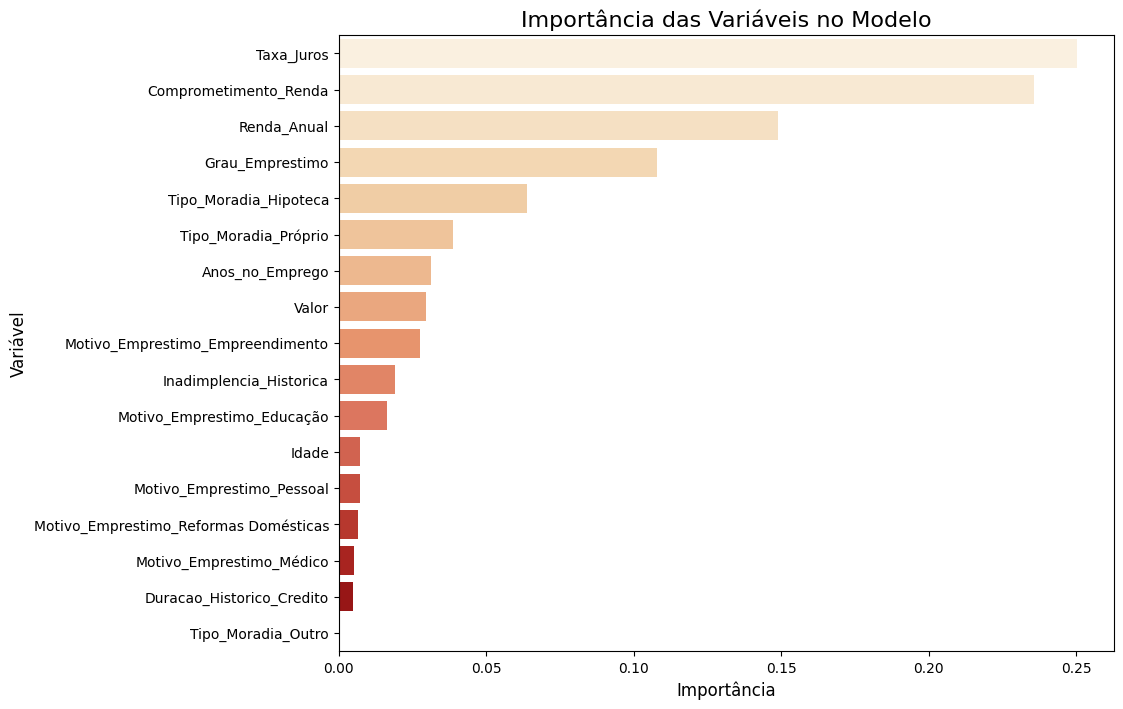

In [141]:
df_importancia = pd.DataFrame({
    'Variavel': X.columns,
    'Importancia': importancia_Var
})

# Ordenar as variáveis por importância
df_importancia = df_importancia.sort_values(by='Importancia', ascending=False)

# Plotar a importância das variáveis
plt.figure(figsize=(10, 8))
sns.barplot(x='Importancia', y='Variavel', data=df_importancia, palette='OrRd')
plt.title('Importância das Variáveis no Modelo', fontsize=16)
plt.xlabel('Importância', fontsize=12)
plt.ylabel('Variável', fontsize=12)
plt.show()

### <font color = "blue"> Conclusões:

- Variável idade já não se mostrava relevante na corr (multicolinearidade com Duração Histórico), agora ainda menos. Vou excluir as duas.
- As demais irei manter, mesmo que vaolor e comprometimento renda possuam 0.64 de correlação, são variáveis relevantes para o problema de negócio